In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import requests
from pathlib import Path

In [2]:
n_samples = 1000
X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 Samples of X: {X[:5]}")
print(f"First 5 Samples of y: {y[:5]}")

First 5 Samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 Samples of y: [1 1 1 1 0]


In [5]:
circles = pd.DataFrame({
    'X1':X[:,0],
    'X2':X[:,1],
    'Labels':y
})

In [6]:
circles.head()

,X1,X2,Labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


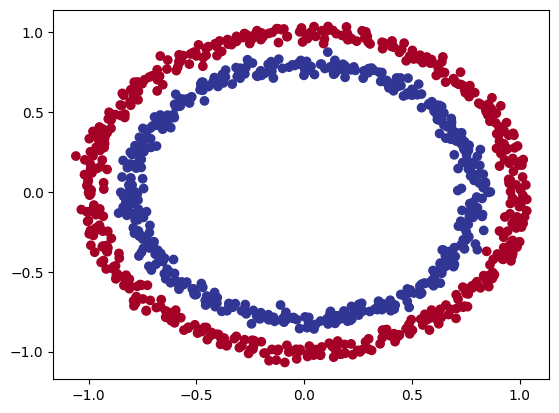

In [7]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [8]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# Numpy array to Tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [12]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [13]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print(f"Length of X_train is {len(X_train)}")
print(f"Length of X_test is {len(X_test)}")
print(f"Length of y_train is {len(y_train)}")
print(f"Length of y_test is {len(y_test)}")

Length of X_train is 800
Length of X_test is 200
Length of y_train is 800
Length of y_test is 200


In [16]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 5)
        self.layer2 = nn.Linear(5,1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

model = CircleModel()
model

CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
# Another way to define the model

# model = nn.Sequential(
#     nn.Linear(X_train.shape[1], 5),
#     nn.Linear(5,1)
# )
# model

In [18]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5275, -0.5237],
                      [-0.1833, -0.7044],
                      [-0.6643,  0.4819],
                      [-0.2035, -0.4749],
                      [-0.6420,  0.2497]])),
             ('layer1.bias',
              tensor([ 0.0753, -0.4332,  0.0916,  0.1463, -0.3772])),
             ('layer2.weight',
              tensor([[-0.1297, -0.2593, -0.3543, -0.3477,  0.3078]])),
             ('layer2.bias', tensor([0.4309]))])

In [19]:
# Important Parameters
learning_rate = 0.1
epochs = 100

In [20]:
# Loss function and Optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
# Calculate Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [22]:
# Step 1 -> Calculate raw Logits

# Logits
model.eval()
with torch.inference_mode():
    y_logits = model(X_test[:5])

y_logits

tensor([[0.5209],
        [0.6444],
        [0.1712],
        [0.6201],
        [0.1299]])

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [24]:
# Step 2 -> Convert these 'logits' into 'prediction probabilities'
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.6274],
        [0.6558],
        [0.5427],
        [0.6502],
        [0.5324]])

In [25]:
# Step 2 -> Convert these 'prediction probabilities' into 'prediction labels'
y_pred_label = torch.round(y_pred_prob)
y_pred_label

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [26]:
y_preds = torch.round(y_pred_prob)
print(torch.eq(y_preds.squeeze(), y_pred_label.squeeze()))
print(y_preds.squeeze())
print(y_pred_label.squeeze())

tensor([True, True, True, True, True])
tensor([1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1.])


In [27]:
torch.manual_seed(42)
for epoch in range(epochs):
    model.train()

    # Training Loop
    # Forward Pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss Function and Accuracy
    loss = loss_function(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # Set gradients to zero
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Update the Parameters
    optimizer.step()

    # Testing Loop
    model.eval()
    with torch.inference_mode():
        # Forward Pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Loss Function and Accuracy
        test_loss = loss_function(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71013 | Accuracy: 51.75% | Test Loss: 0.72061 | Test Accuracy: 52.00%
Epoch: 10 | Loss: 0.70086 | Accuracy: 55.75% | Test Loss: 0.70972 | Test Accuracy: 53.50%
Epoch: 20 | Loss: 0.69684 | Accuracy: 53.00% | Test Loss: 0.70442 | Test Accuracy: 49.50%
Epoch: 30 | Loss: 0.69505 | Accuracy: 52.50% | Test Loss: 0.70164 | Test Accuracy: 46.50%
Epoch: 40 | Loss: 0.69420 | Accuracy: 52.00% | Test Loss: 0.70002 | Test Accuracy: 47.00%
Epoch: 50 | Loss: 0.69377 | Accuracy: 51.62% | Test Loss: 0.69899 | Test Accuracy: 47.50%
Epoch: 60 | Loss: 0.69353 | Accuracy: 51.12% | Test Loss: 0.69826 | Test Accuracy: 46.50%
Epoch: 70 | Loss: 0.69338 | Accuracy: 51.12% | Test Loss: 0.69771 | Test Accuracy: 46.00%
Epoch: 80 | Loss: 0.69328 | Accuracy: 51.62% | Test Loss: 0.69728 | Test Accuracy: 45.50%
Epoch: 90 | Loss: 0.69321 | Accuracy: 51.38% | Test Loss: 0.69693 | Test Accuracy: 45.50%


In [28]:
if Path('helper_functions.py').is_file():
    print(f"File already exists, skipping download")
else:
    print(f'Downloading helper_functions.py')
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open('helper_functions.py','wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary        

File already exists, skipping download


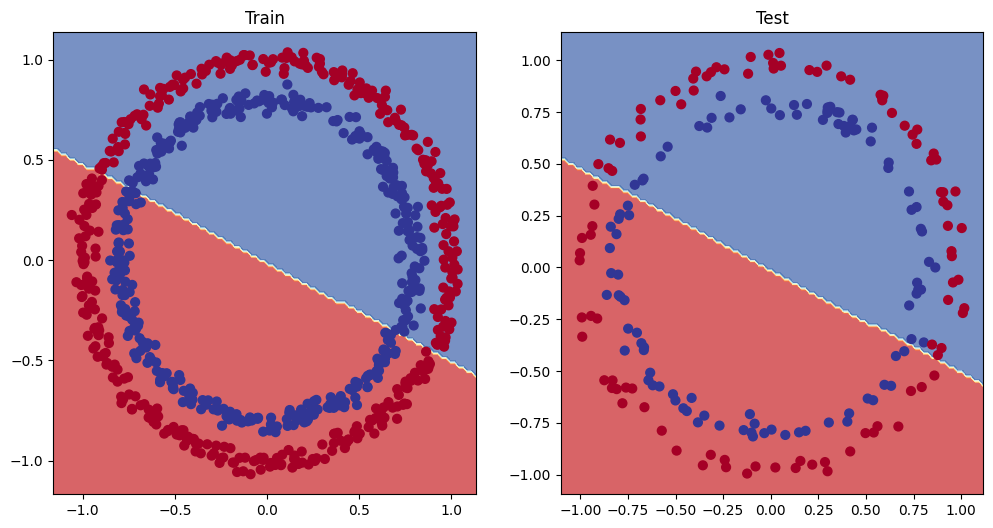

In [29]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

In [53]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(X_train.shape[1], 10)
        self.linear2 = nn.Linear(10,10)
        self.linear3 = nn.Linear(10,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model1 = CircleModelV1()
model1

CircleModelV1(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [31]:
# Important Parameters
learning_rate = 0.1
epochs = 1000

In [32]:
# Loss function and Optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)

In [33]:
torch.manual_seed(42)
for epoch in range(epochs):
    model1.train()

    # Training Loop
    # Forward Pass
    y_logits = model1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss Function and Accuracy
    loss = loss_function(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

     # Set gradients to zero
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Update the Parameters
    optimizer.step()

    # Training Loop
    model1.eval()
    with torch.inference_mode():
        # Forward Pass
        test_logits = model1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Loss Function and Accuracy
        test_loss = loss_function(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295 | Accuracy: 50.00% | Test Loss: 0.69319 | Test Accuracy: 50.00%
Epoch: 10 | Loss: 0.69248 | Accuracy: 50.50% | Test Loss: 0.69260 | Test Accuracy: 50.00%
Epoch: 20 | Loss: 0.69225 | Accuracy: 59.13% | Test Loss: 0.69231 | Test Accuracy: 56.50%
Epoch: 30 | Loss: 0.69209 | Accuracy: 70.25% | Test Loss: 0.69212 | Test Accuracy: 68.00%
Epoch: 40 | Loss: 0.69195 | Accuracy: 68.38% | Test Loss: 0.69195 | Test Accuracy: 71.00%
Epoch: 50 | Loss: 0.69181 | Accuracy: 58.25% | Test Loss: 0.69177 | Test Accuracy: 58.00%
Epoch: 60 | Loss: 0.69168 | Accuracy: 54.00% | Test Loss: 0.69161 | Test Accuracy: 54.50%
Epoch: 70 | Loss: 0.69155 | Accuracy: 53.12% | Test Loss: 0.69146 | Test Accuracy: 53.00%
Epoch: 80 | Loss: 0.69141 | Accuracy: 52.62% | Test Loss: 0.69132 | Test Accuracy: 53.00%
Epoch: 90 | Loss: 0.69128 | Accuracy: 52.75% | Test Loss: 0.69117 | Test Accuracy: 53.00%
Epoch: 100 | Loss: 0.69115 | Accuracy: 52.88% | Test Loss: 0.69102 | Test Accuracy: 52.50%
Epoch: 110

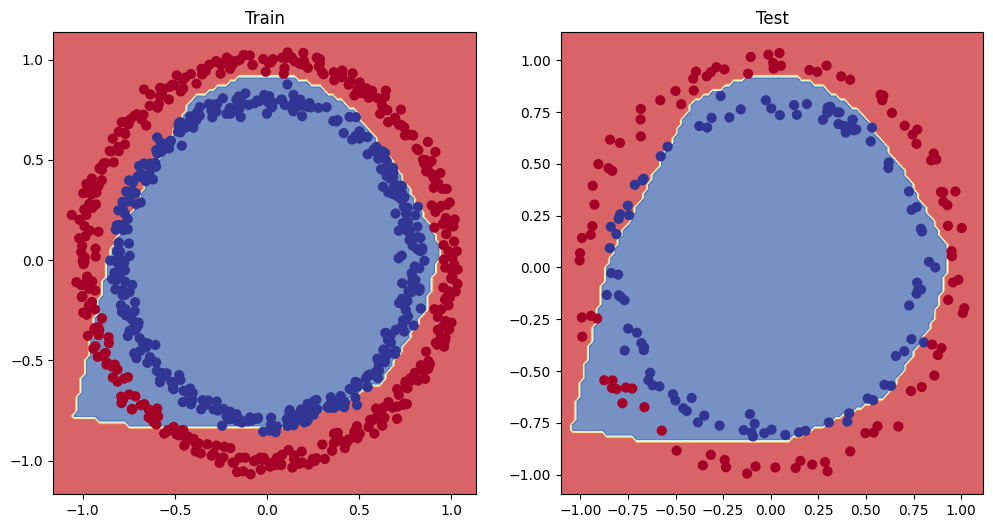

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

In [36]:
# Studying ReLU and Sigmoid

In [37]:
A = torch.arange(-10,10,1, dtype=torch.float32)

In [38]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

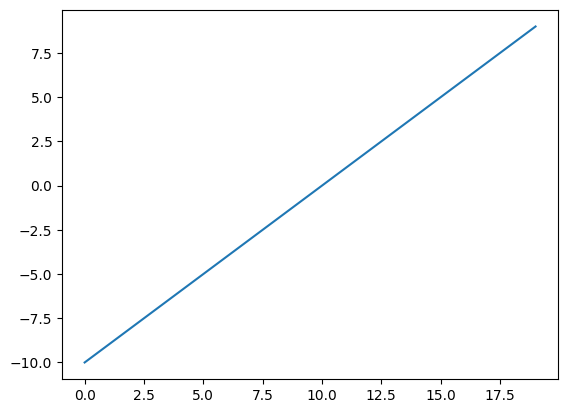

In [40]:
plt.plot(A)

Text(0.5, 1.0, 'Built-in ReLU')

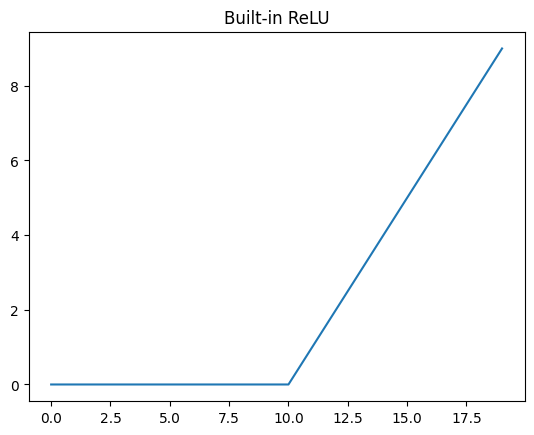

In [44]:
plt.plot(torch.relu(A))
plt.title('Built-in ReLU')

In [45]:
def relu(x:torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

relu(A)    

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

Text(0.5, 1.0, 'Function Defined ReLU')

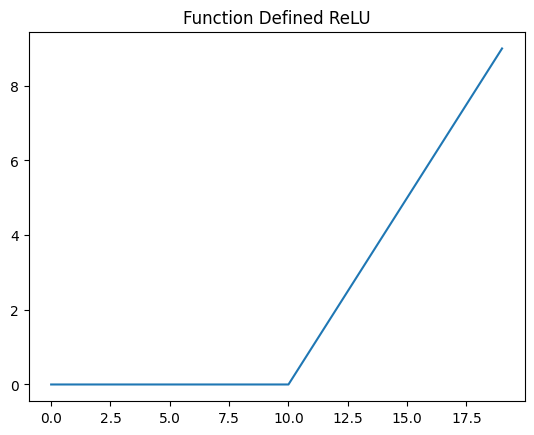

In [47]:
plt.plot(relu(A))
plt.title('Function Defined ReLU')

Text(0.5, 1.0, 'Built-in Sigmoid')

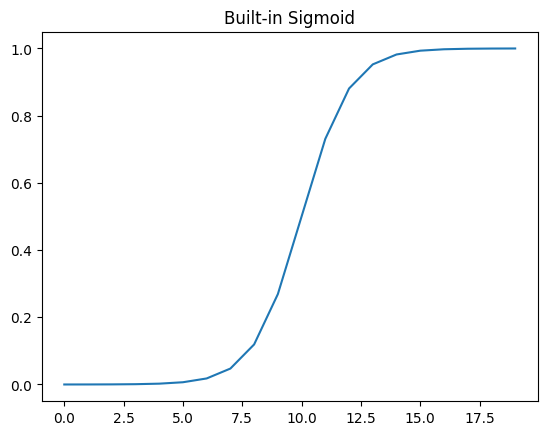

In [48]:
plt.plot(torch.sigmoid(A))
plt.title('Built-in Sigmoid')

In [51]:
def sigmoid(x:torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

sigmoid(A)    

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

Text(0.5, 1.0, 'Function Defined Sigmoid')

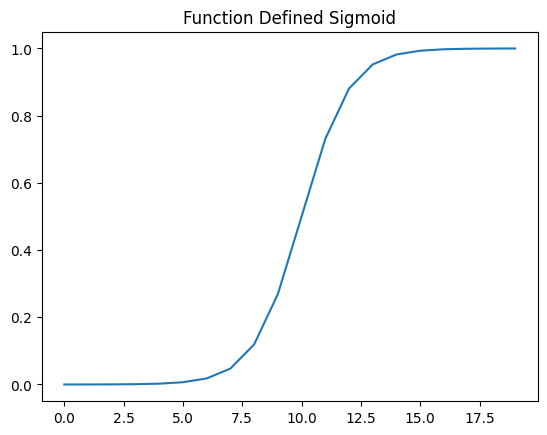

In [52]:
plt.plot(sigmoid(A))
plt.title('Function Defined Sigmoid')